# Random Forest Model

In [1]:
# importing some needed modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# importing the data
filename = 'drugAbuse_data_cleaned_model_ready.csv'
df = pd.read_csv(filename)

In [3]:
df.drop(columns=['Unnamed: 0'],inplace=True)

Let's write a function to print out the results on the training data, as well as the test data, given a model.

In [4]:
# import some modules we may need
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# function to describe model results
# model must already be fitted
def model_results(model,X,y):
    
    y_pred = model.predict(X)
    print("Results")
    print("\n")
    # accuracy score
    print("Accuracy Score: {}".format(accuracy_score(y_pred,y)))

    # classification report 
    print("Classification Report: \n {}".format(classification_report(y,y_pred)))

    # confusion matrix 
    print("Confusion Matrix: \n {}".format(confusion_matrix(y,y_pred)))

    # AUC score 
    print("AUC Score: {}".format(roc_auc_score(y,model.predict_proba(X)[:,1])))

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    

Now, we will implement our random forest model. We will use RandomizedSearchCV to tune the parameters for the number of trees and the max_depth. Moreover, this time, we will use 'recall' as our best scoring metric because we can still end up with high accuracy scores, as well as high AUC scores, and still predict 'Severe Psychological Distress' incorrectly much of the time. 

Tuned Random Forest Parameters: {'n_estimators': 100, 'max_depth': 4}
Best score on training set is 0.200272731547
Results


Accuracy Score: 0.893897746014
Classification Report: 
              precision    recall  f1-score   support

          0       0.89      1.00      0.94      9752
          1       1.00      0.00      0.01      1162

avg / total       0.91      0.89      0.84     10914

Confusion Matrix: 
 [[9752    0]
 [1158    4]]
AUC Score: 0.657385077636


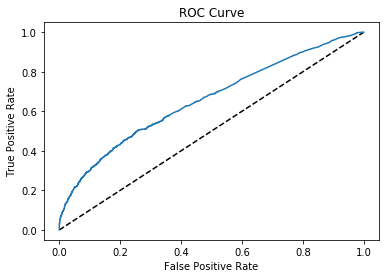

CPU times: user 47.8 s, sys: 399 ms, total: 48.2 s
Wall time: 48.7 s


In [5]:
%%time
# create our X and y
X = df.drop(columns=['Severe Psychological Distress Past Month'])
y = df['Severe Psychological Distress Past Month'].values

# we are using RandomizedSearchCV to see what the best number of trees for our model
# because it would take a too much computational time to use GridSearch
n_trees = [10,20,50,100,500,1000]
possible_max_depths = [1,2,3,4,5]
param_grid = {'n_estimators':n_trees,
             'max_depth':possible_max_depths}

# instantiate the classifier
random_forest = RandomForestClassifier()

# instantiate the GridSearchCV object
cv = RandomizedSearchCV(random_forest,param_grid,cv=5,scoring='average_precision')
# we are more interested in seeing how correctly
# the classifier predicts severe psychological distress correctly

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=26)

# fit the model
cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(cv.best_params_)) 
print("Best score on training set is {}".format(cv.best_score_))

model_results(cv,X_train,y_train)

random_forest = RandomForestClassifier(n_estimators=(cv.best_params_)['n_estimators'],
                                      max_depth=(cv.best_params_)['max_depth'])
random_forest.fit(X_train,y_train)

As we can see, our model performed very poorly. Moreover, implementing RandomizedSearchCV and testing our model took about 1 minute implement. This could be due to a few different reasons. Perhaps, we are using too many features to classify our data. We may also not be tuning our hyperparameters properly.

Let's write a function to print the 'n' most important features of a random forest model, so we can see what features are having a strong impact on the model.

In [6]:
def n_most_important_features(df,y_column,model,n,print_feature_importances=False):
    """Returns and/or prints a list of the n most important features of a random forest model"""
    feature_importances = list(model.feature_importances_)
    # let's print out a list of the n most important features
    
    most_important_features = []
    for i in range(1,n+1):
        feature_importance = (sorted(feature_importances))[-1*i]
        index = feature_importances.index(feature_importance)
        if (print_feature_importances):
            print(`(df.drop(columns=[y_column]).columns)[index]`
              +": "+`feature_importance`+" (Index: " + `index` + ")")
        most_important_features.append((df.drop(columns=[y_column]).columns)[index])
    return most_important_features

Let's try another model by tuning some more hyperparameters. We never tried using the 'balanced' class_weight attribute: this could be useful since we have a higher proportion of individuals that do not have severe psychological score in the past month.

Tuned Random Forest Parameters: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 3, 'class_weight': 'balanced'}
Results


Accuracy Score: 0.67024005864
Classification Report: 
              precision    recall  f1-score   support

          0       0.93      0.69      0.79      9752
          1       0.17      0.53      0.26      1162

avg / total       0.84      0.67      0.73     10914

Confusion Matrix: 
 [[6695 3057]
 [ 542  620]]
AUC Score: 0.641660027547


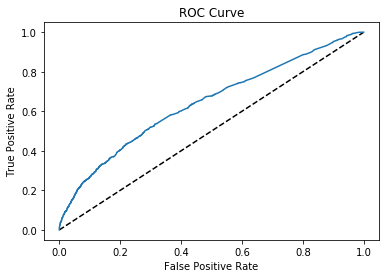

CPU times: user 16.3 s, sys: 307 ms, total: 16.6 s
Wall time: 17 s


In [7]:
%%time
# we are using RandomizedSearchCV to see what the best number of trees for our model
# because it would take a too much computational time to use GridSearch
from scipy.stats import randint
n_trees = [10,20,50,100]
possible_max_depths = [3,5,None]
# tuning some more hyperparameters this time
param_grid = {'n_estimators':n_trees,
             'max_depth':possible_max_depths,
             "max_features":['log2','sqrt'],
             "class_weight":['balanced']}

# instantiate the classifier
random_forest = RandomForestClassifier()

# instantiate the GridSearchCV object
cv = RandomizedSearchCV(random_forest,param_grid,cv=5,scoring='average_precision')

# fit the model
cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(cv.best_params_)) 

model_results(cv,X_train,y_train)

Now, let's see if using the 25 most important features improves model performance at all.

'First Used Marijuana Prior to 21': 0.1355345754175447 (Index: 36)
'# Days Used Marijuana Past Year': 0.12215029494944556 (Index: 5)
'First Used Marijuana Prior to 18': 0.11724225225255015 (Index: 22)
'Alcohol Dependence in Past Year': 0.08719388707117054 (Index: 26)
'Marijuana Recency': 0.06763456338538656 (Index: 10)
'Marijuana Dependence in Past Year': 0.06021126871421822 (Index: 33)
'# Days Used Marijuana Past Year (Range)': 0.04459479655853556 (Index: 2)
'First Used Cocaine Prior to 21': 0.03980401631848509 (Index: 37)
'First Used Alcohol Prior to 18': 0.03930886101449957 (Index: 32)
'First Used Hallucinogens Prior to 18': 0.036207498607984535 (Index: 24)
'Cocaine Recency': 0.027582735701004793 (Index: 8)
'# Days Used Cocaine Past Year': 0.024261426993441693 (Index: 4)
'LSD Recency': 0.020660667786749253 (Index: 13)
'# Days Used Marijuana Past Month': 0.0202704405864593 (Index: 11)
'First Used Cocaine Prior to 18': 0.020081557963661626 (Index: 27)
'First Used Hallucinogens Prior t

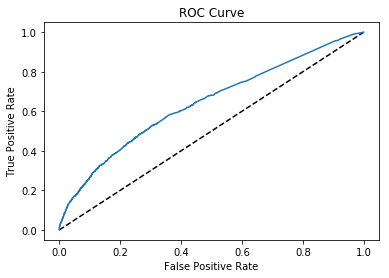

In [8]:
test_rf_model = RandomForestClassifier(**cv.best_params_)
test_rf_model.fit(X_train,y_train)
twenty_five_most_important_features = n_most_important_features(df,'Severe Psychological Distress Past Month',
                                                                test_rf_model,25,print_feature_importances=True)
test_rf_model.fit(X_train[twenty_five_most_important_features],y_train)
model_results(test_rf_model,X_train[twenty_five_most_important_features],y_train)

Our results don't change much, and we get a little bit less accurate. Thus, we will keep all the features as long as they don't affect the complexity of the problem.

# Testing the model

Let's see how our current model performs on the test data.

In [9]:
test_rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Results


Accuracy Score: 0.648804616653
Classification Report: 
              precision    recall  f1-score   support

          0       0.92      0.66      0.77      3255
          1       0.16      0.53      0.24       384

avg / total       0.84      0.65      0.72      3639

Confusion Matrix: 
 [[2159 1096]
 [ 182  202]]
AUC Score: 0.640178971454


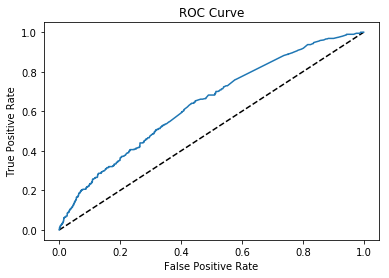

In [10]:
model_results(test_rf_model,X_test,y_test)

As we can see from the results, our model performed about the same on the testing data. We may not have an overfit model, but we still don't necessarily have a particularly accurate one.